In [185]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, multilabel_confusion_matrix

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from feature_classifier_utils import ensemble_voting, GridSVM, Lasso_feature_selection
from feature_performance_utils import load_texture_feature,\
                                        load_clinical_data,\
                                        save_confusion_matrix,\
                                        Validation, \
                                        normal_porosis,\
                                        save_roc_curve, \
                                        dummy_labelize_swk, \
                                        binarize_threshold_swk

from random import shuffle

from sklearn.preprocessing import StandardScaler

In [2]:
def save_prediction(feature_index, y_pred, y_pred_proba, y_test, filename, binary):
    
    if binary :

        data = {
            'true label' : y_test,
            'pred label' : y_pred,
            'confidence score for class 0' : y_pred_proba.T[0],
            'confidence score for class 1' : y_pred_proba.T[1]
        }
        
        pd.DataFrame(index=feature_index, data=data).to_excel(filename)
        return 
    else:
        
        data = {
            'true label' : y_test,
            'pred label' : y_pred,
            'confidence score for class 0' : y_pred_proba.T[0],
            'confidence score for class 1' : y_pred_proba.T[1],
            'confidence score for class 2' : y_pred_proba.T[2]
        }
        
        pd.DataFrame(index=feature_index, data=data).to_excel(filename)
        return

def binary_class_configuration(feature_data, feature_label, delete_label):
    
    resampled_feature_data = []
    resampled_feature_label = []
    
    for d, l in zip(feature_data, feature_label):
        
        if l == int(delete_label):
            continue
            
        else:
            resampled_feature_data.append(d)
            resampled_feature_label.append(l)
    
    return np.array(resampled_feature_data), np.array(resampled_feature_label)

### Concatenate Clinical data to feature data

In [3]:
texture_features = ['../result/left_mask.csv', '../result/right_mask.csv']
label_file = '../data/label_dict.pickle'
clinical_file = '../data/clinical_data.pickle'

with open(label_file, 'rb') as file: label_dict = pickle.load(file)
with open(clinical_file, 'rb') as file: clinical_dict = pickle.load(file)
    
feature_names = np.array(list(pd.read_csv(texture_features[0]).columns)[1:])

whole_feature = []
whole_label = []
whole_subjects = []

for texture_feature in texture_features:
#     print(texture_feature)
    
    for key, value in pd.read_csv(texture_feature).iterrows():

        subject = '_'.join(list(value)[0].split('_')[:-1])
        label = label_dict[subject]
        clinic_data = clinical_dict[subject] # is male, is female, age

#         print(key, list(value)[0], len(list(value[1:])), label, clinic_data)
        
        whole_feature.append(list(value[1:]) + clinic_data)
        whole_label.append(label)
        whole_subjects.append(list(value)[0])

#         break

whole_feature = np.array(whole_feature)
whole_label = np.array(whole_label)
        
print('Whole feature :',np.array(whole_feature).shape) # (270 = 135 + 135, 854 = 851 + 3)
print('Whole labels :', np.array(whole_label).shape)
print('Whole subjects :', len(whole_subjects))
print('Number by labels :',Counter(whole_label))

Whole feature : (270, 854)
Whole labels : (270,)
Whole subjects : 270
Number by labels : Counter({1: 92, 2: 90, 0: 88})


### Feature Analysis with Lasso

- LASSO feature Extraction Method applied 
- Scaled data ( x - mean / std ) were used ( mean, std from train dataset were applied to test dataset )

In [4]:
def heatmap(label, figsize=(10,10), tr=0):
    fig, ax = plt.subplots(figsize=figsize)
#     label = np.log2(label[:num_samples])
#     print(label)
    sns.heatmap(label.T,
                yticklabels=False,
                xticklabels=False,
                vmin=-0.05,
                vmax=0.95,
#                 center=0,
                cmap='RdYlGn_r',
               cbar=True)
    plt.savefig('../figure/cn_ad_heatmap/heatmap_without_labels_%.2f.png'%tr)
    plt.xlabel('features'); plt.ylabel('texture feature')
    plt.xticks(np.arange(2) + len(label)/2, ['AD', 'CN'])
#     plt.yticks(np.arange(len(y_ticks))+0.5, y_ticks)
    plt.savefig('../figure/cn_ad_heatmap/heatmap_with_labels_%.2f.png'%tr)
    plt.show(); plt.close()
    return

In [172]:
imp_features = np.load('../result/imp_features_common.npy')

imp_feature_index = [index for index, x in enumerate(feature_names) if x in imp_features]

In [190]:
num_try = 10
try_dict = dict()

# feature_data = feature_data_with_clinical
highest_acc = 0.0
binary = False

classification_result_save_dir = '../classification_result/cn_mci_ad/'
target_names = ['CN', 'MCI', 'AD']
# delete_label = 2

internal_feature_data = whole_feature
internal_feature_label = np.array(whole_label)

# if Bianary remove MCI
if binary:
    internal_feature_data, internal_feature_label = \
                        binary_class_configuration(internal_feature_data, internal_feature_label, delete_label)
    
    # 2 label ==> 1 label / 1 이 사라졌기 때문에..!
#     internal_feature_label[internal_feature_label == 1] = 0
#     internal_feature_label[internal_feature_label == 2] = 1

scaler = StandardScaler()

# trs = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
#  first try : 23, 18, 13, 8, 8, 6, 4, 3

trs = [0.02] # 4
p_value_by_feature = dict()
result_each_trial = []
num_samples = 70
figsize = (60,10) # 가로, 세로

for i in range(num_try):
    
    print("++++++++++")
    print(i+1 , "st try")
    print("++++++++++\n")
        
    # train test set divide
    X_train, X_test, y_train, y_test = train_test_split(internal_feature_data,
                                                        internal_feature_label,
                                                        test_size=0.20,
                                                        random_state=42+i,
                                                        stratify = internal_feature_label)
        
    X_train_resampled, Y_train_resampled = X_train, y_train

    # Scale dataset
    scaler.fit(X_train_resampled)
    X_train_scaled = scaler.transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    for i, tr in enumerate(trs):

#         Texture Feature Selection using LASSO
#         sfm = Lasso_feature_selection(X_train_scaled[:, :-3], Y_train_resampled, tr=tr)
#         num_selected_feature = len(np.where(sfm.get_support() == True)[0])
    
#         print(i+1,'Number of Feature Selected with ', tr , ':', num_selected_feature)

#         X_train_new = np.hstack([sfm.transform(X_train_scaled[:, :-3]), X_train_scaled[:, -3:]])
#         X_test_tr = np.hstack([sfm.transform(X_test_scaled[:, :-3]), X_test_scaled[:, -3:]])
        
        # Sampling with p-value important features
        X_train_new = np.hstack([np.array([X_train_scaled[:, i] for i in imp_feature_index]).T, X_train_scaled[:, -3:]])
        X_test_tr = np.hstack([np.array([X_test_scaled[:, i] for i in imp_feature_index]).T, X_test_scaled[:, -3:]])

        # After Feature Selection
#         if i == 0 :
            
#             label_1 = X_train_new[:, :-3][y_train == 1]
#             label_0 = X_train_new[:, :-3][y_train == 0]

#             shuffle(label_1)
#             shuffle(label_0)
#             heatmap(np.concatenate([label_1, label_0]), figsize=figsize, tr=tr)

        # model
        clf = ensemble_voting(X_train_new, Y_train_resampled, random_state=42+i, cv=5)

#         train
        clf.fit(X_train_new, Y_train_resampled)

#         # evaluation

        print('================================')
#         print("Test with ", num_selected_feature, " features")
#         Validation 
#         internal_result = Validation(clf, X_test_tr, y_test)
#         result_each_trial.append(list(internal_result))
#         if i == 0:
        
#             label_1 = X_test_tr[:, :-3][y_test == 1]
#             label_0 = X_test_tr[:, :-3][y_test == 0]

#             shuffle(label_1)
#             shuffle(label_0)
            
#             heatmap(np.concatenate([label_1, label_0]), figsize=figsize, tr=tr)

        #This is for Wilcoxon Test
#         for index, feature_name in enumerate(feature_names[np.where(sfm.get_support() == True)]):

#             T, p_value = stats.wilcoxon(label_0[:num_samples].T[index], label_1[:num_samples].T[index])
        
#             try:
#                 p_value_by_feature[feature_name].append(p_value)

#             except:
#                 p_value_by_feature[feature_name] = [p_value]
        
        # multilabel 에 대한 confusion matrix 를 어떻게 구할까.. 3차원인가 ??
#         confusion = internal_result[-1]; save_confusion_matrix(confusion, conf_index, conf_cols, "Internal Validation Confusion matrix")

#         y_pred_proba = clf.predict_proba(X_test_tr); y_pred = clf.predict(X_test_tr)
    
#         print(roc_auc_score(y_test, y_pred_proba, 'weighted'))
#         print(clf.score(X_test_tr, y_test))
#         print(classification_report(y_test, y_pred, target_names=target_names, output_dict=False))

#         save_prediction(np.arange(len(y_pred)), y_pred, y_pred_proba, y_test,\
#                          os.path.join(classification_result_save_dir , str(num_selected_feature)+'.xlsx'),
#                        binary=binary)

    print('================================')

#     break

# np.save('../result/result_each_trial_mci_cn.npy', result_each_trial)

# with open('../result/feature_pvalue_mci_cn.pickle', 'wb') as file:
#     pickle.dump(p_value_by_feature, file)

# with open('../result/feature_pvalue_mci_cn.pickle', 'rb') as file:
#     x = pickle.load(file)

print('done')


++++++++++
1 st try
++++++++++

Ensemble Voting Grid search running...
Random Forest Grid search running...
{'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
XGBoost Grid search running...
{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500}
Adaboost Grid search running...
{'learning_rate': 0.1, 'n_estimators': 100}
Estimators Ready
Voting Classifier Grid search running ... 
{'voting': 'soft'}
done
              precision    recall  f1-score   support

          CN       0.76      0.72      0.74        18
         MCI       0.44      0.44      0.44        18
          AD       0.58      0.61      0.59        18

    accuracy                           0.59        54
   macro avg       0.60      0.59      0.59        54
weighted avg       0.60      0.59      0.59        54

[[[32  4]
  [ 5 13]]

 [[26 10]
  [10  8]]

 [[28  8]
  [ 7 11]]]
++++++++++
2 st try
++++++++++

Ensemble Voting Grid search running.

{'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500}
Adaboost Grid search running...
{'learning_rate': 0.01, 'n_estimators': 200}
Estimators Ready
Voting Classifier Grid search running ... 
{'voting': 'soft'}
done
              precision    recall  f1-score   support

          CN       0.65      0.72      0.68        18
         MCI       0.53      0.56      0.54        18
          AD       0.67      0.56      0.61        18

    accuracy                           0.61        54
   macro avg       0.61      0.61      0.61        54
weighted avg       0.61      0.61      0.61        54

[[[29  7]
  [ 5 13]]

 [[27  9]
  [ 8 10]]

 [[31  5]
  [ 8 10]]]
++++++++++
10 st try
++++++++++

Ensemble Voting Grid search running...
Random Forest Grid search running...
{'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 300}
XGBoost Grid search running...
{'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 7, 'n_e

In [174]:
from scipy import stats


for i, value in enumerate(['accuracy', 'AUROC', 'Precision', 'F1 Score']):
    aucs = np.array([a[i] for a in result_each_trial])
    res_mean, res_var, res_std = stats.bayes_mvs(aucs, alpha=0.95)
    
    print('\n')
    print(value)
    print(res_mean)
    print(res_var)
    print(res_std)
    print('-'*10)



accuracy
Mean(statistic=0.686388888888889, minmax=(0.6709121110289821, 0.701865666748796))
Variance(statistic=0.006209351533664249, minmax=(0.004690062076797792, 0.008210172167516622))
Std_dev(statistic=0.07859661240531102, minmax=(0.06848402789554504, 0.09061000037256715))
----------


AUROC
Mean(statistic=0.8058024691358026, minmax=(0.7933865850128942, 0.818218353258711))
Variance(statistic=0.003996137752448474, minmax=(0.0030183722124294803, 0.005283801178728516))
Std_dev(statistic=0.06305229944570313, minmax=(0.05493971434608557, 0.07268975979275565))
----------


Precision
Mean(statistic=0.7245830004097127, minmax=(0.70245929516689, 0.7467067056525354))
Variance(statistic=0.012688225150872178, minmax=(0.00958370021077877, 0.01677671370739757))
Std_dev(statistic=0.1123520865699066, minmax=(0.09789637486025093, 0.1295249539949641))
----------


F1 Score
Mean(statistic=0.6518739389234427, minmax=(0.6245939859053243, 0.6791538919415611))
Variance(statistic=0.01929178375857683, minma

In [54]:
np.argmax(np.array([len(x) for x in p_by_feature.values()]))

len(p_by_feature['glrlm_ShortRunHighGrayLevelEmphasis_wv_3'])

100

In [56]:
with open('../result/feature_pvalue_ad_mci.pickle', 'wb') as file:
    pickle.dump(p_by_feature, file)

with open('../result/feature_pvalue_ad_mci.pickle', 'rb') as file:
    x = pickle.load(file)
    
print(x)

{'shape_Sphericity': [0.001007436529450086, 0.0003264782848128665, 0.06399596863607886, 0.001007436529450086, 0.3060456527573018, 0.000736675759382907, 0.0003264782848128665, 0.0006198817771393389, 2.6588322235921982e-08, 7.255233358612419e-09, 6.531340334788166e-12, 8.339848893118762e-12, 1.8166684788104287e-10, 4.3365444636385674e-10, 8.088458973118634e-11, 8.695939213640108e-12, 3.66630574985915e-12, 3.592869862267084e-10, 1.3379205180160037e-10, 1.5598585113939016e-10, 1.9607144480258214e-12, 1.1321515563230214e-12, 1.3051730475852467e-11, 1.8015915219769488e-11, 1.4090781334596258e-07, 3.0912106714606947e-07, 2.4856205850717997e-08, 2.3736022668708585e-10, 1.8012357268600012e-11, 6.093607488524119e-09, 4.502588806355292e-10, 7.383016287768696e-12, 1.13731889524028e-08, 1.6840110587498172e-10, 3.842154893163342e-11, 7.485372326559176e-11, 3.028430085508568e-11, 4.497461726544193e-11, 2.560407366997872e-10, 8.011127665661177e-12, 6.656763884634935e-11, 9.106293421802731e-10, 1.28603

In [26]:
Counter(Y_train_resampled)

# - test set 을 balancing 하여 평가하였다
#TODO 1: Confusion Matrix
#TODO 2: AUROC score with multiple labels
#TODO 3: 

Counter({1: 74, 2: 72, 0: 70})

## Heatmap

1 Number of Feature Selected with  0.02 : 2
['glrlm_ShortRunHighGrayLevelEmphasis_wv_3'
 'gldm_SmallDependenceHighGrayLevelEmphasis_wv_7']


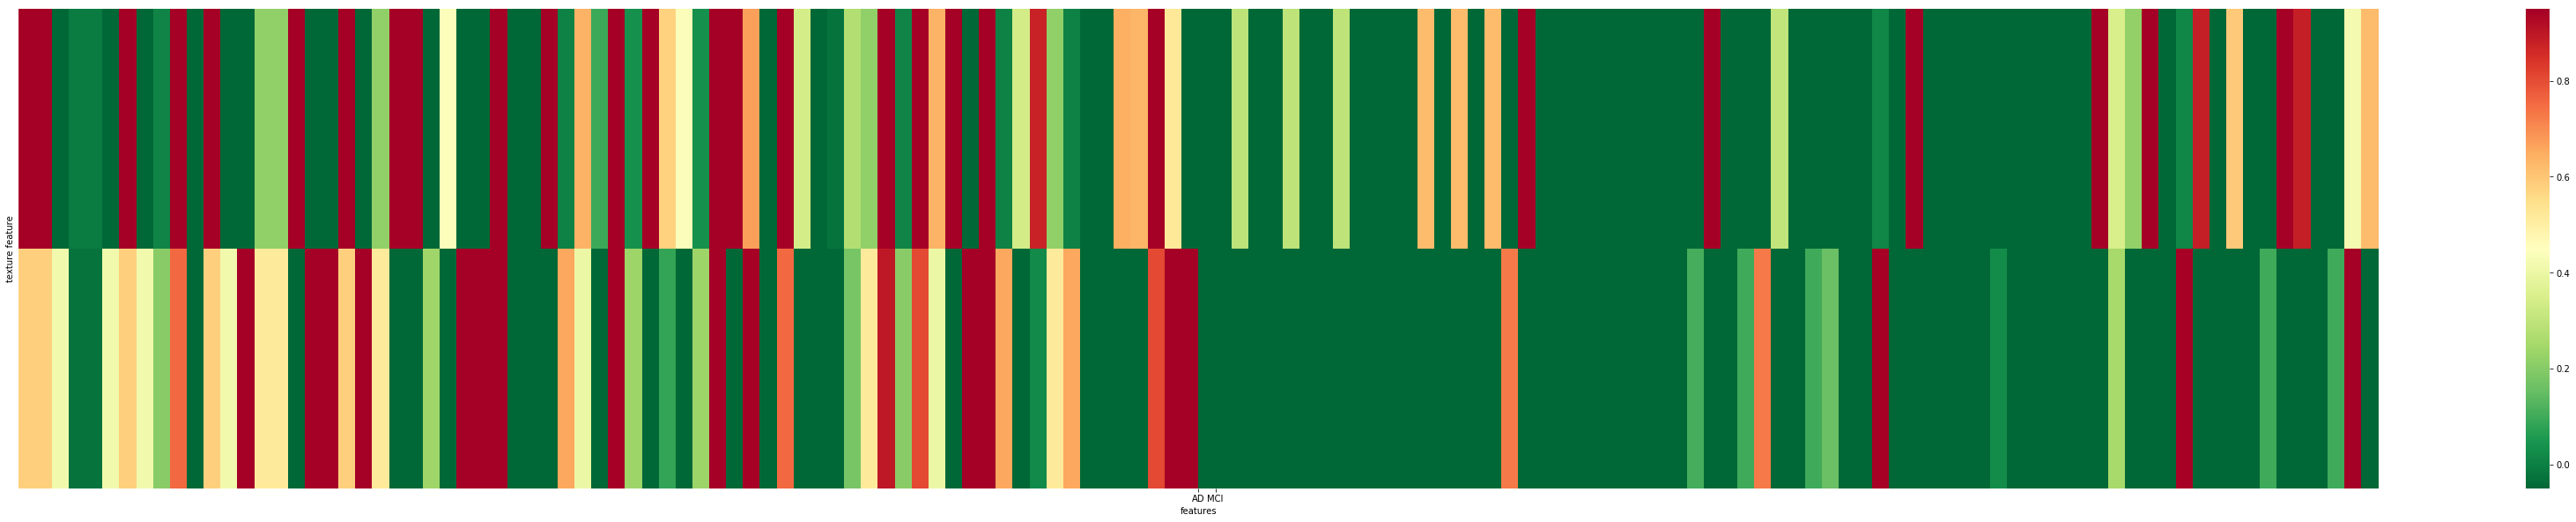

2 Number of Feature Selected with  0.03 : 1
['gldm_LargeDependenceLowGrayLevelEmphasis_wv_7']


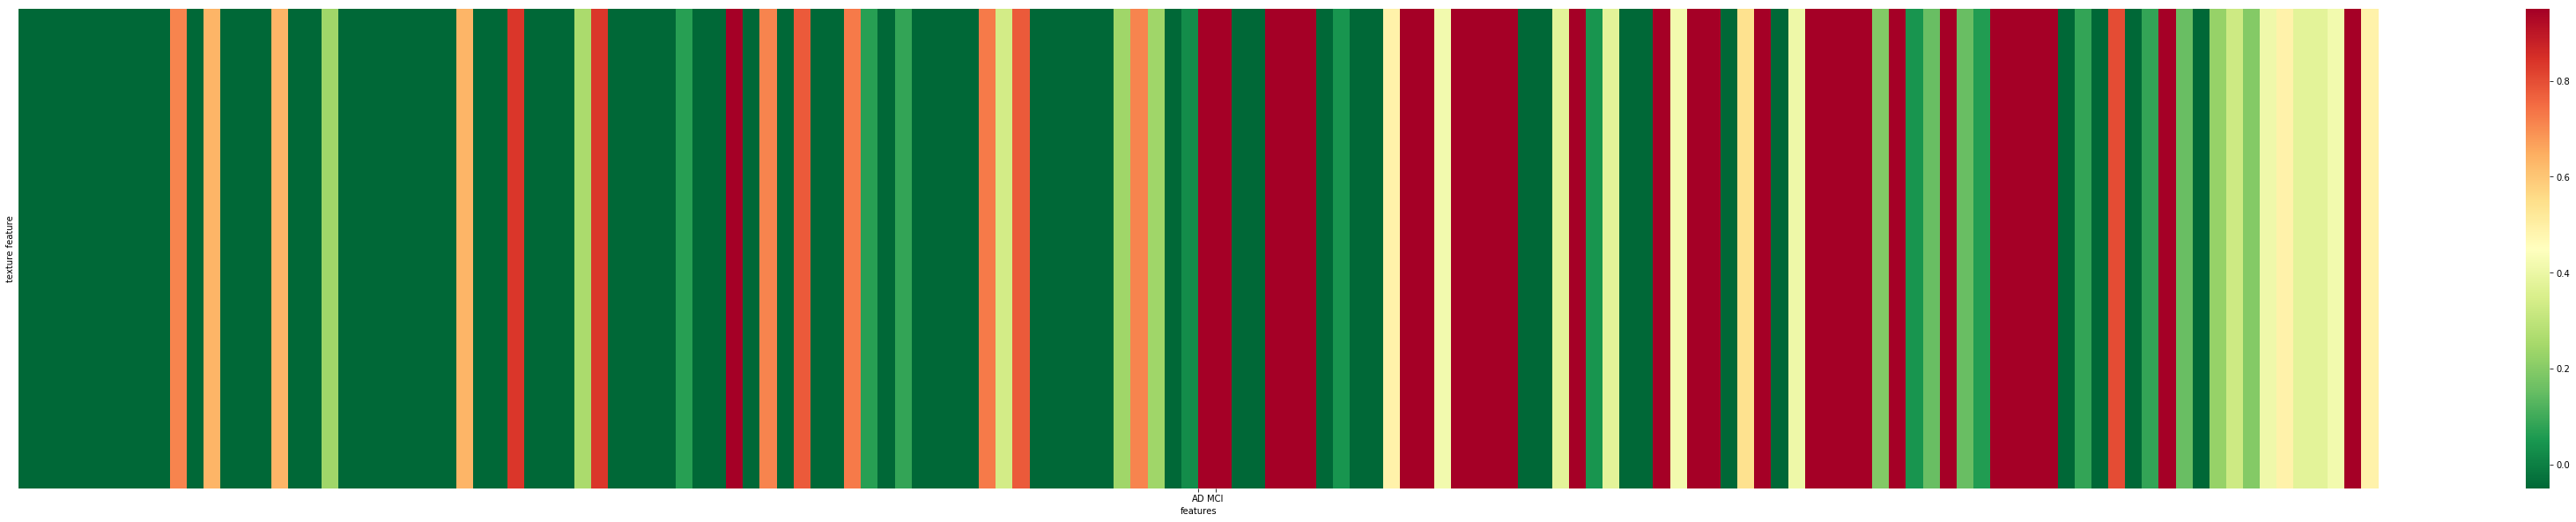

3 Number of Feature Selected with  0.04 : 1
['glrlm_ShortRunHighGrayLevelEmphasis_wv_3']


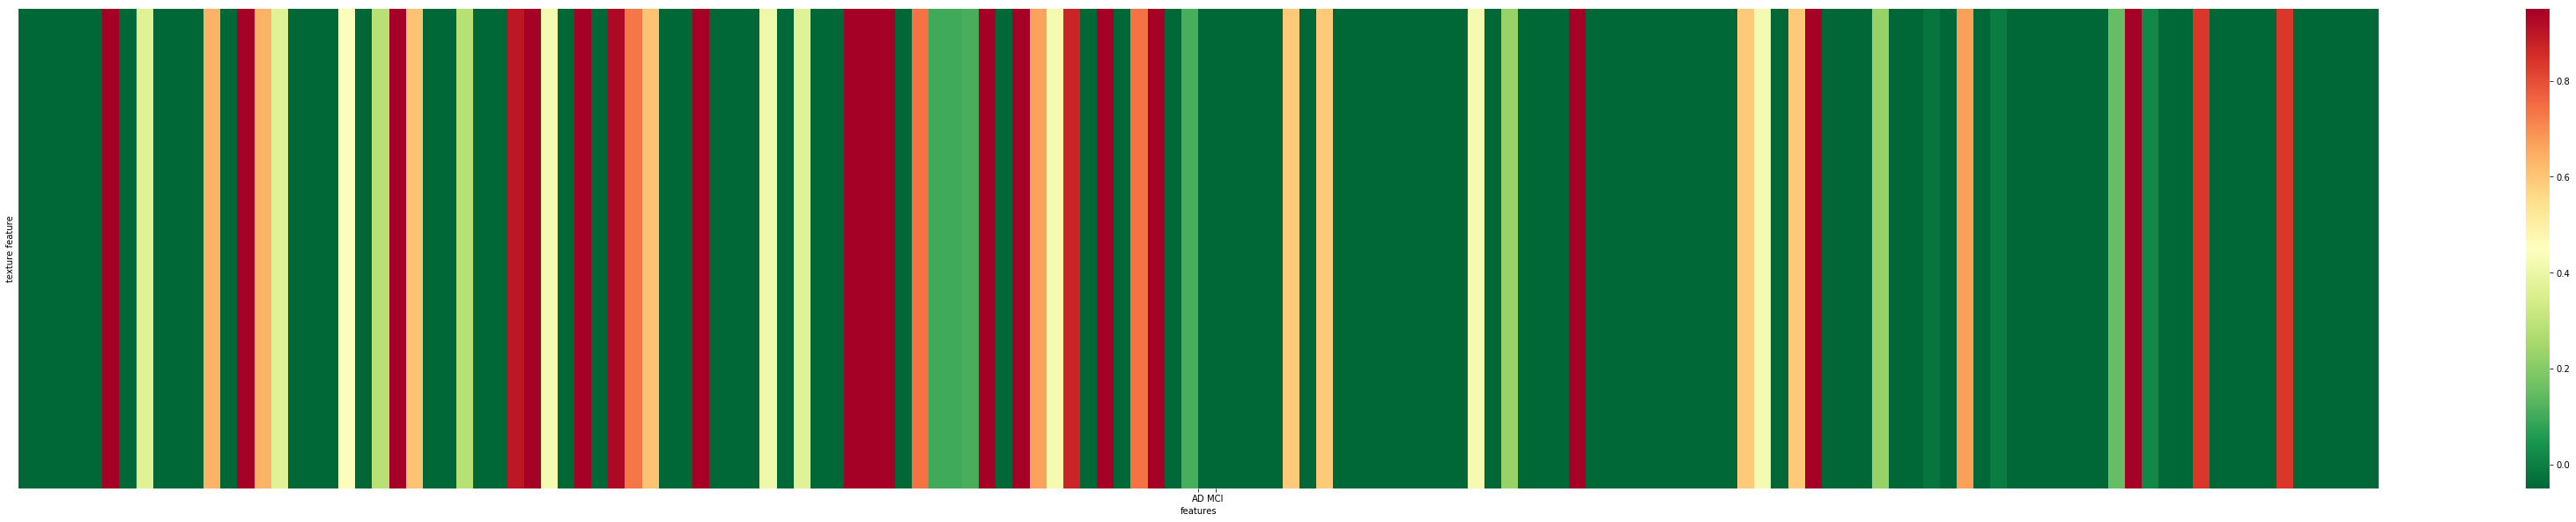

4 Number of Feature Selected with  0.05 : 1
['glrlm_ShortRunHighGrayLevelEmphasis_wv_3']


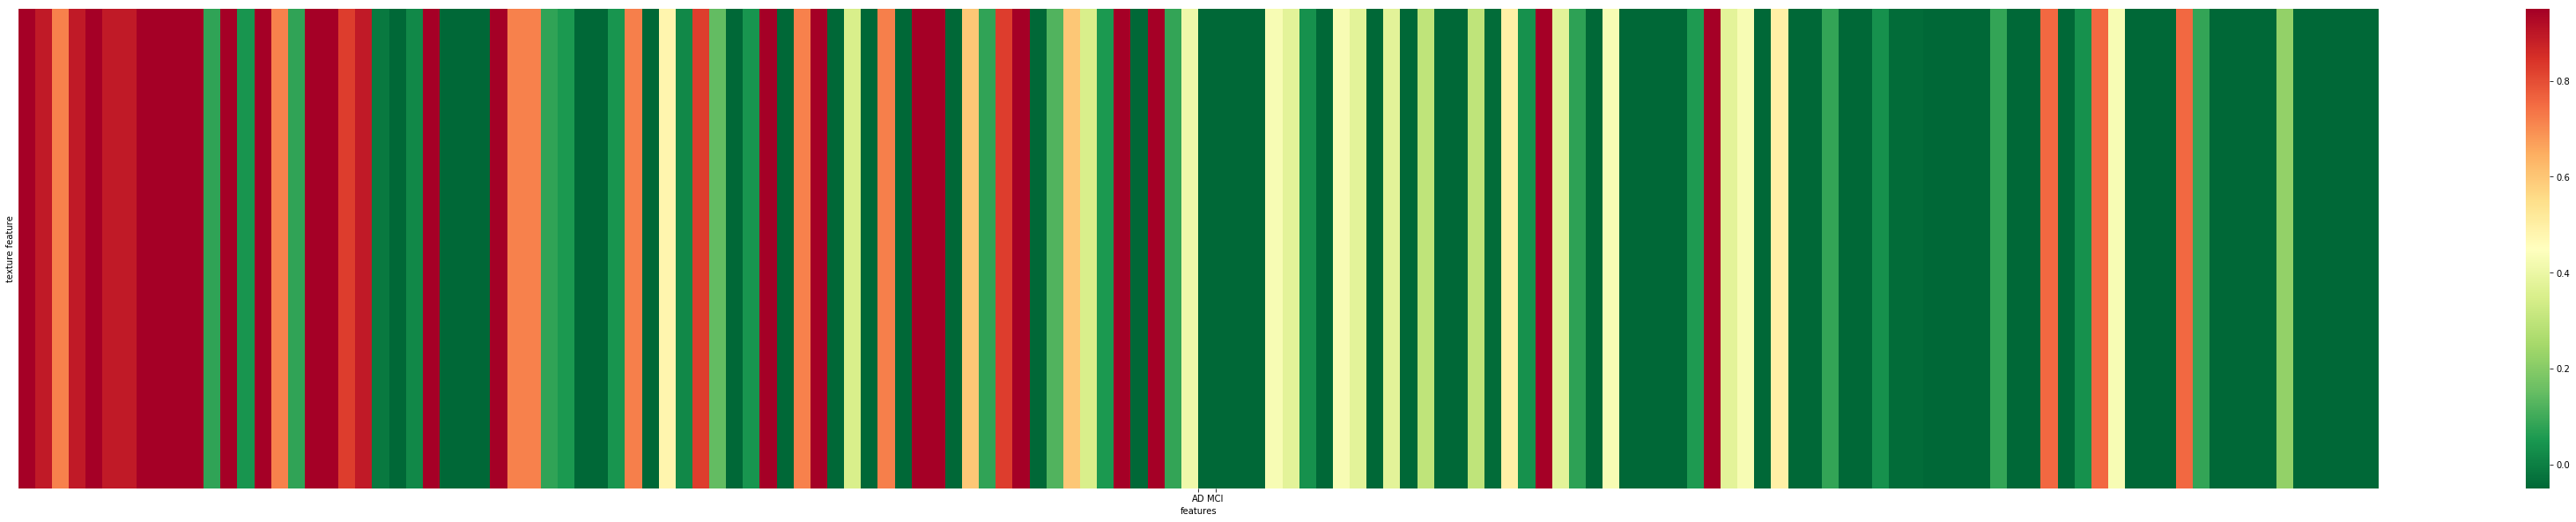

In [93]:
trs = [0.02, 0.03, 0.04, 0.05]

for i, tr in enumerate(trs):
    
    # feature_data = feature_data_with_clinical
    binary = True
    target_names = ['MCI', 'AD']
    delete_label = 0
    
    internal_feature_data = whole_feature
    internal_feature_label = whole_label

    # if Bianary remove MCI
    if binary:
        internal_feature_data, internal_feature_label= \
                            binary_class_configuration(internal_feature_data, internal_feature_label, delete_label)

        # 2 label ==> 1 label / 1 이 사라졌기 때문에..!
        internal_feature_label[internal_feature_label == 1] = 0
        internal_feature_label[internal_feature_label == 2] = 1
    
    # train test set divide
    X_train, X_test, y_train, y_test = train_test_split(internal_feature_data,
                                                        internal_feature_label,
                                                        test_size=0.20,
                                                        random_state=42+i+i,
                                                        stratify = internal_feature_label)

    # Scale dataset
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Texture Feature Selection
    sfm = Lasso_feature_selection(X_train_scaled[:, :-3], y_train, tr=tr)
    num_selected_feature = len(np.where(sfm.get_support() == True)[0])
    print(i+1,'Number of Feature Selected with ', tr , ':', num_selected_feature)
    
    X_train_new = np.hstack([sfm.transform(X_train_scaled[:, :-3]), X_train_scaled[:, -3:]])

    label_1 = X_train_new[:, :-3][y_train == 1]
    label_0 = X_train_new[:, :-3][y_train == 0]
    
    shuffle(label_1)
    shuffle(label_0)
    
    num_samples = 70
    figsize = (60,10) # 가로, 세로
    
    print(feature_names[np.where(sfm.get_support() == True)])

    # After Feature Selection
    heatmap(np.concatenate([label_1[:num_samples], label_0[:num_samples]]), figsize=figsize, tr=tr)

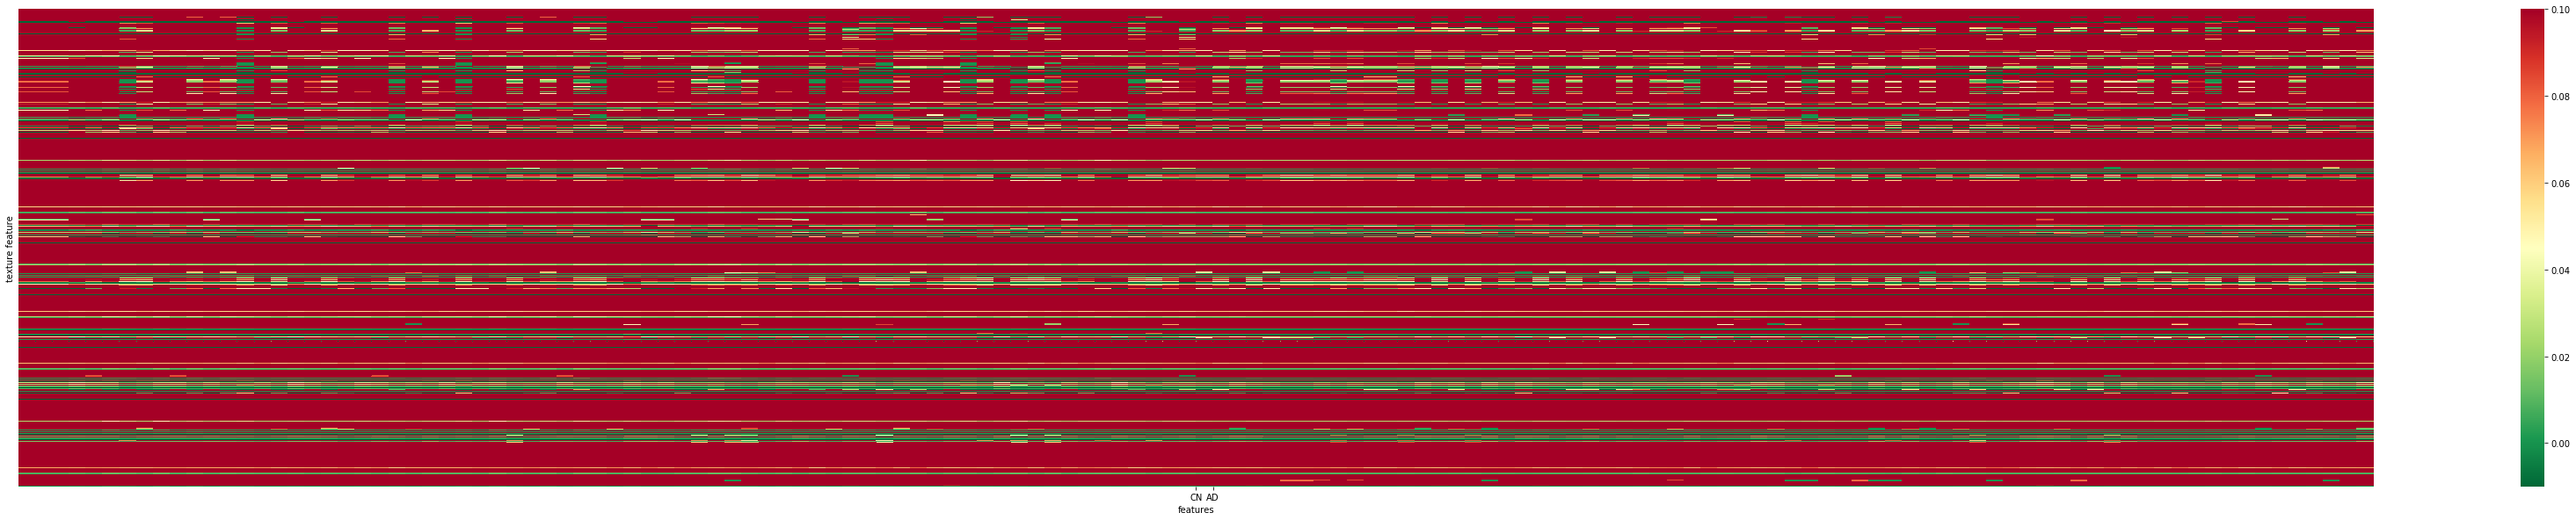

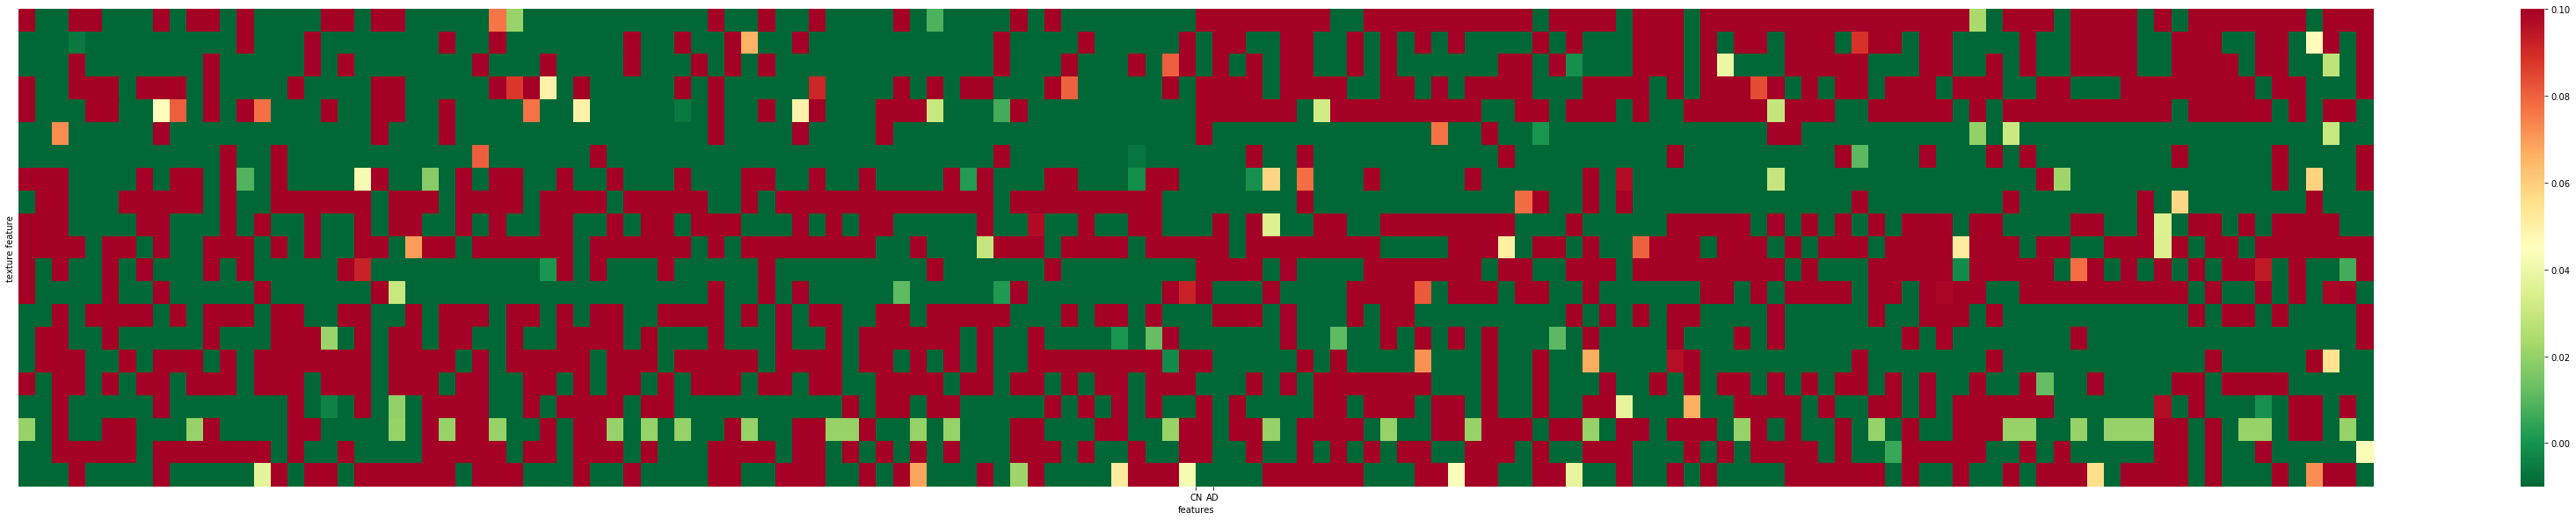

In [59]:
num_samples = 70
figsize = (60,10) # 가로, 세로

label_1 = X_train[:, :-3][y_train == 1]
label_0 = X_train[:, :-3][y_train == 0]

shuffle(label_1)
shuffle(label_0)

# Before Feature Selection
heatmap(np.concatenate([label_1[:num_samples], label_0[:num_samples]]), figsize=figsize)

label_1 = X_train_new[:, :-3][y_train == 1]
label_0 = X_train_new[:, :-3][y_train == 0]

# After Feature Selection
heatmap(np.concatenate([label_1[:num_samples], label_0[:num_samples]]), figsize=figsize)

In [93]:
print(whole_feature.shape)

(270, 854)


(270, 2)


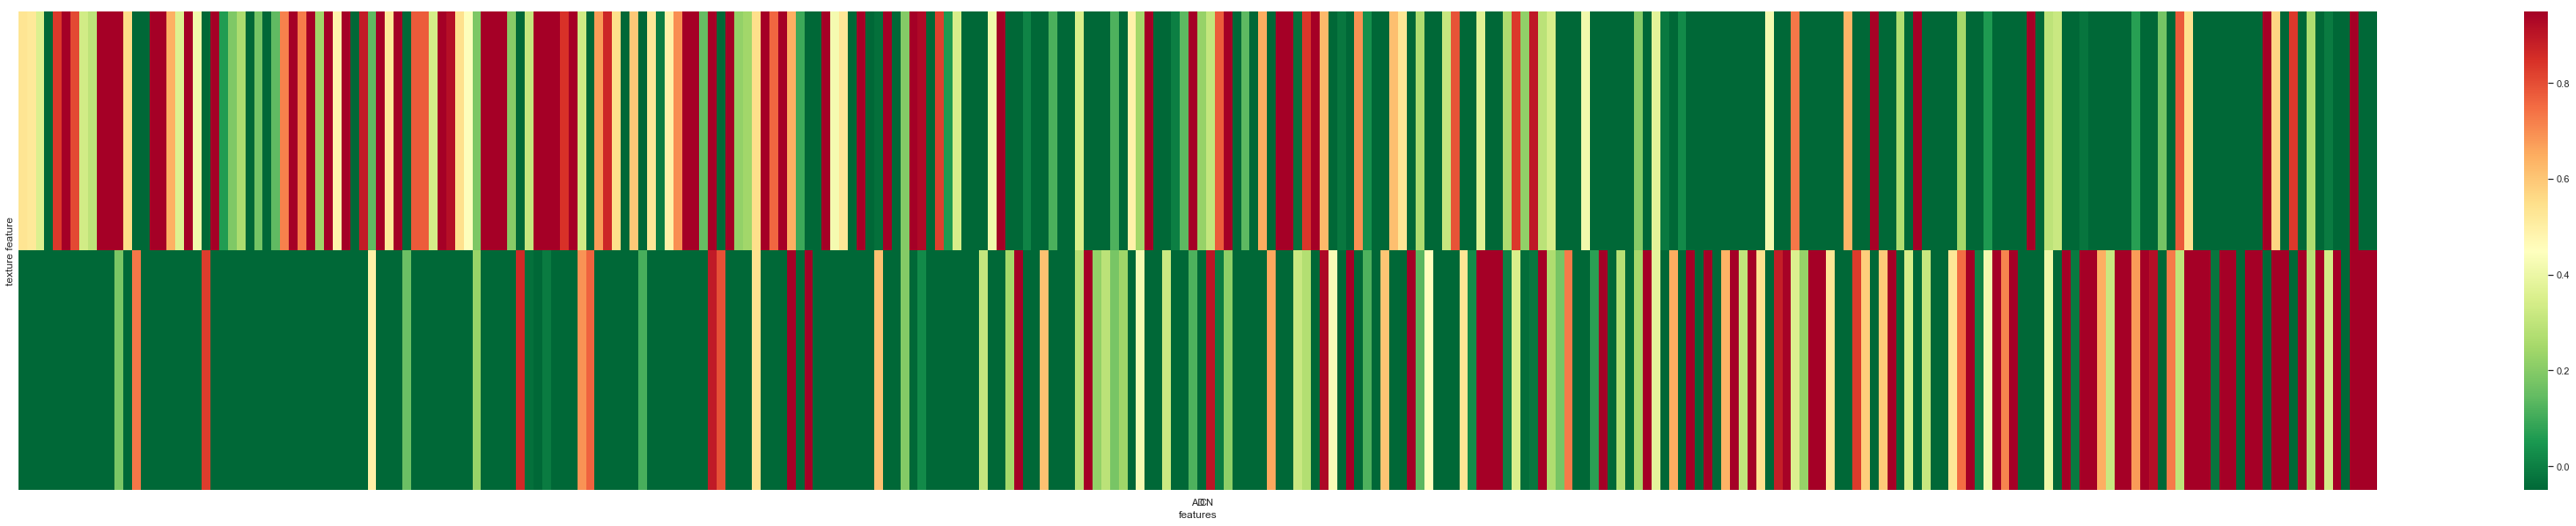

In [175]:
imp_features = np.load('../result/imp_features_common.npy')
imp_feature_index = [index for index, x in enumerate(feature_names) if x in imp_features]

whole_feature_scaled = scaler.fit_transform(whole_feature[:, :-3])

X_selected = np.array([whole_feature_scaled[:, i] for i in imp_feature_index]).T

print(X_selected.shape)

# # After Feature Selection
# if i == 0 :

label_2 = X_selected[whole_label == 2]
label_1 = X_selected[whole_label == 1]
label_0 = X_selected[whole_label == 0]

heatmap(np.concatenate([label_0, label_1, label_2]), figsize=figsize, tr=0)


### Histogram

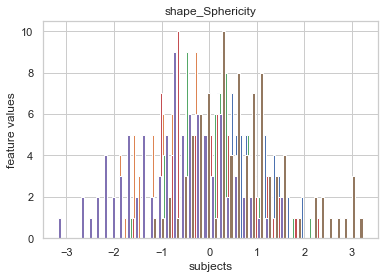

In [176]:
plt.hist(label_0, bins=40)
plt.hist(label_1, bins=40)
plt.hist(label_2, bins=40)
plt.title(imp_features[0])
plt.xlabel('subjects')
plt.ylabel('feature values')
plt.show()
plt.close()

### Scatter plot of the feature

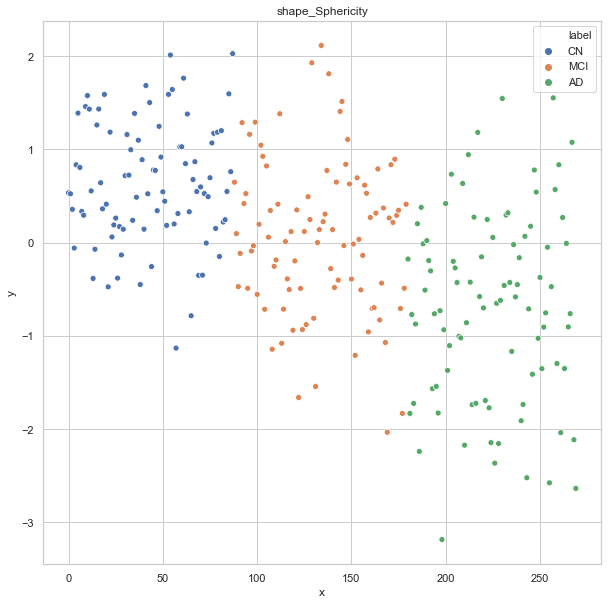

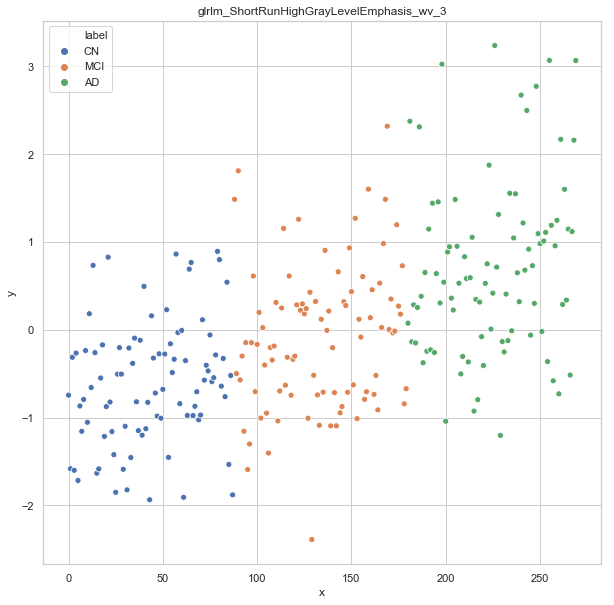

In [179]:
label_conversion = {
    0 : 'CN',
    1 : 'MCI',
    2 : 'AD'
}

num_labels = np.concatenate([label_0, label_1, label_2]).shape[0]

x = np.arange(num_labels)
y = np.concatenate([label_0, label_1, label_2])
lb = [label_conversion[a] for a in sorted(whole_label)]

for i in range(len(imp_features)):

    data= pd.DataFrame(dict(x=x, y=y.T[i], label=lb))
    
    plt.figure(figsize=(10, 10))
    plt.title('%s'%imp_features[i])
    sns.scatterplot(x='x',
                    y='y',
                   hue='label',
                   data=data)

### Box plot of the feature

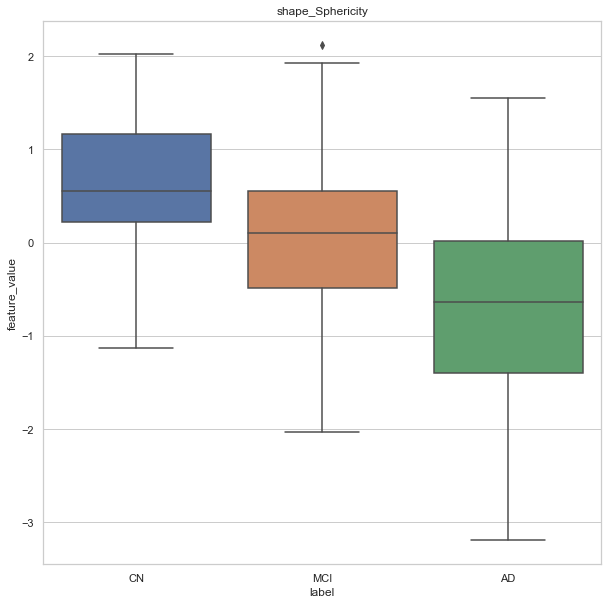

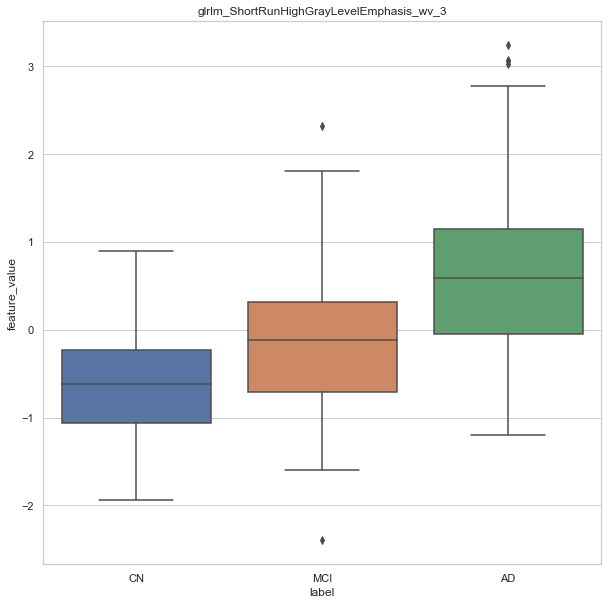

In [181]:
# x = dict(cn=label_0.T[0][:88], mci=label_1.T[0][:88], ad=label_2.T[0][:88])
# data

for i in range(len(imp_features)):
    
    x = dict(label = [label_conversion[a] for a in sorted(whole_label)], feature_value = np.concatenate([label_0, label_1, label_2]).T[i])

    data = pd.DataFrame(data=x)

    fig = plt.figure(figsize=(10,10))
    plt.title('%s'%imp_features[i])
    sns.boxplot(x='label',y='feature_value', data=data)